### Dataset Description
The dataset contains bird images, divided into train and test splits. The images are inside test_images and train_images folders.

The labels of the training images are inside train_images.csv file. In this file, the first column is image_path and the second one is the label (1 - 200). The test_images_samples.csv includes a row id with a dummy label. The final goal of the challenge is to change the label column to the predicted label.

The class_names.npy is a dictionary including the name of each label. Load the file using the following code: np.load("class_names.npy", allow_pickle=True).item()

The structure of the final submission should be exactly the same as the test_images_samples.csv! Otherwise, it will fail.

Files

- train_images - the training images
- test_images - the test images
- test_images_sample.csv - a sample submission file in the correct format
- test_images_path.csv - path to test file images
- train_images.csv - supplemental information about the data
- class_names.npy - this file includes the name of each label
- attributes.npy - this file includes the attributes which are extra information for each class.
- attributes.txt - this file includes the attribute names which are extra information for each class.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_data_path = '/content/drive/MyDrive/UvA Data Science/AMS_feathers_in_focus-main'

#change gdrive wd
os.chdir(base_data_path)
print(f"wd changed to: {os.getcwd()}")

In [1]:
# Setup and imports
import numpy as np
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
import os


batch_size = 32
learning_rate = 0.0001
max_lr = 0.003
weight_decay = 0.0004
num_epochs = 100
num_classes = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_split = 0.2
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
print(device)

cuda


**Exploring class features**

In [ ]:
class_names = np.load("../class_names.npy", allow_pickle=True).item()
print(F"First class: {class_names}")
attributes = np.load("../attributes.npy", allow_pickle=True)
print(F"Attributes shape: {attributes.shape}")


First class: {np.str_('001.Black_footed_Albatross'): 1, np.str_('002.Laysan_Albatross'): 2, np.str_('003.Sooty_Albatross'): 3, np.str_('004.Groove_billed_Ani'): 4, np.str_('005.Crested_Auklet'): 5, np.str_('006.Least_Auklet'): 6, np.str_('007.Parakeet_Auklet'): 7, np.str_('008.Rhinoceros_Auklet'): 8, np.str_('009.Brewer_Blackbird'): 9, np.str_('010.Red_winged_Blackbird'): 10, np.str_('011.Rusty_Blackbird'): 11, np.str_('012.Yellow_headed_Blackbird'): 12, np.str_('013.Bobolink'): 13, np.str_('014.Indigo_Bunting'): 14, np.str_('015.Lazuli_Bunting'): 15, np.str_('016.Painted_Bunting'): 16, np.str_('017.Cardinal'): 17, np.str_('018.Spotted_Catbird'): 18, np.str_('019.Gray_Catbird'): 19, np.str_('020.Yellow_breasted_Chat'): 20, np.str_('021.Eastern_Towhee'): 21, np.str_('022.Chuck_will_Widow'): 22, np.str_('023.Brandt_Cormorant'): 23, np.str_('024.Red_faced_Cormorant'): 24, np.str_('025.Pelagic_Cormorant'): 25, np.str_('026.Bronzed_Cowbird'): 26, np.str_('027.Shiny_Cowbird'): 27, np.str_('0

### Setting up dataset and dataloaders
creating stratified train and validation set (80:20)

In [3]:
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset, Subset

torch.manual_seed(42)

class BirdDataset(Dataset):
    def __init__(self, csv_file, root_dir, img_col_idx, label_col_idx, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.img_col_idx = img_col_idx
        self.label_col_idx = label_col_idx
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = str(self.data.iloc[idx, self.img_col_idx])
        clean_filename = filename.lstrip('/').lstrip('\\')
        img_path = os.path.join(self.root_dir, clean_filename)

        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, OSError):
            print(f"Could not open {img_path}, using black image.")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # Raw CSV is 1-200. We subtract 1 to get 0-199 for PyTorch.
        raw_label = int(self.data.iloc[idx, self.label_col_idx])
        label = raw_label - 1

        # Transform
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    ),
    transforms.RandomErasing(p=0.15)
])

#Validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
from sklearn.model_selection import StratifiedKFold

full_train_dataset = BirdDataset('../train_images.csv', '../train_images', 0, 1, transform=train_transform)
full_val_dataset   = BirdDataset('../train_images.csv', '../train_images', 0, 1, transform=val_transform)

#lab -1 for CE Loss
labels = full_train_dataset.data.iloc[:, 1].values - 1

skf = StratifiedKFold(
    n_splits=int(1 / val_split),
    shuffle=True,
    random_state=seed
)

# Take the first fold
for train_idx, val_idx in skf.split(np.zeros(len(labels)), labels):
    break

train_dataset = Subset(full_train_dataset, train_idx)
val_dataset   = Subset(full_val_dataset,   val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

print(f"Training set: {len(train_dataset)}")
print(f"Validation set: {len(val_dataset)}")

Training set: 3140
Validation set: 786


**Setting up test set**

In [ ]:
test_dataset  = BirdDataset('../test_images_path.csv', '../test_images', 1, 2, transform=val_transform)
test_loader = DataLoader(
    test_dataset, 
    batch_size=256,    
    num_workers=0,     
    shuffle=False
)

print(f"Test set: {len(test_dataset)} images to predict.")

Test set: 4000 images to predict.


In [8]:
test_iter = iter(test_loader)
images, labels = next(test_iter)

print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)
print("First 5 labels:", labels[:5])

Batch shape: torch.Size([256, 3, 224, 224])
Labels shape: torch.Size([256])
First 5 labels: tensor([0, 0, 0, 0, 0])


**Load a batch with labels for a manual check**

Labels in batch: [136, 19, 28, 41, 150, 174, 75, 59, 98, 71, 120, 50, 1, 148, 66, 178, 29, 76, 33, 62, 16, 6, 79, 39, 131, 34, 12, 88, 84, 35, 101, 7]


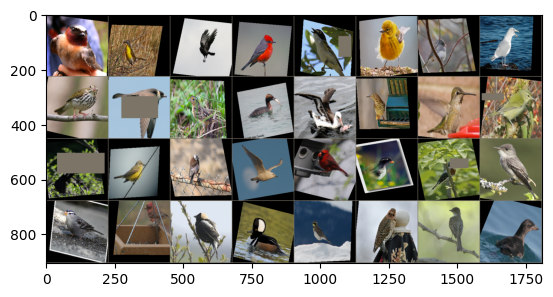

In [9]:
import matplotlib.pyplot as plt

def show_img(img):
    # Denormalize the image for proper display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean # de-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Labels in batch:", labels.tolist())
show_img(torchvision.utils.make_grid(images, nrow = 8))

### Convolutional Neural Network

In [10]:
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN_extended(nn.Module):
    def __init__(self, num_classes): #With num_classes already define the last layers output
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,32, kernel_size= 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024,num_classes)
        )

    def forward(self, x):
        x= self.layer1(x)
        x= self.layer2(x)
        x= self.layer3(x)
        x= self.layer4(x)
        x= self.layer5(x)

        x= self.global_pool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x

In [11]:
import torch.optim as optim

num_classes = len(class_names)
model = SimpleCNN_extended(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


In [ ]:
model = SimpleCNN_extended(num_classes=200) 
model.load_state_dict(torch.load("../Models/cnn_extended.pth", map_location=device))
model.to(device)

print("Model loaded")

model.eval()
all_predictions = []

with torch.no_grad():  # Don't calculate gradients
    for images, _ in test_loader:
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())

submission = pd.read_csv('../test_images_sample.csv')

if len(submission) != len(all_predictions):
    print(f"Sample has {len(submission)} rows but predicted {len(all_predictions)}")

submission['label'] = [p + 1 for p in all_predictions]

submission.to_csv('../Submission_csv/submission_extended_cnn.csv', index=False)
print("submission_extended_cnn.csv saved")

Model loaded
submission_extended_cnn.csv saved


TRAINING THE MODEL DONT RUN


In [ ]:
n_epoch = 50
best_acc = 0.0

for epoch in range(n_epoch):
    #train
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    #val
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * correct / total

    print(
        f"Epoch {epoch+51}/{n_epoch}, "
        f"Train loss: {avg_train_loss:.3f}, "
        f"Val loss: {avg_val_loss:.3f}, "
        f"Val acc: {val_acc:.1f}%"
    )
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "../Models/cnn_extended.pth")
        print(f"Saved new best model ({val_acc:.2f}%)")



Epoch 51/50, Train loss: 3.612, Val loss: 4.235, Val acc: 12.1%
Saved new best model (12.09%)
Epoch 52/50, Train loss: 3.596, Val loss: 4.238, Val acc: 12.2%
Saved new best model (12.21%)
Epoch 53/50, Train loss: 3.555, Val loss: 4.183, Val acc: 12.5%
Saved new best model (12.47%)
Epoch 54/50, Train loss: 3.511, Val loss: 4.167, Val acc: 13.2%
Saved new best model (13.23%)
Epoch 55/50, Train loss: 3.538, Val loss: 4.301, Val acc: 12.2%
Epoch 56/50, Train loss: 3.506, Val loss: 4.123, Val acc: 12.1%
Epoch 57/50, Train loss: 3.441, Val loss: 4.114, Val acc: 12.8%
Epoch 58/50, Train loss: 3.423, Val loss: 4.145, Val acc: 12.8%
Epoch 59/50, Train loss: 3.448, Val loss: 4.423, Val acc: 12.2%
Epoch 60/50, Train loss: 3.380, Val loss: 4.063, Val acc: 13.9%
Saved new best model (13.87%)
Epoch 61/50, Train loss: 3.426, Val loss: 4.143, Val acc: 14.0%
Saved new best model (13.99%)
Epoch 62/50, Train loss: 3.350, Val loss: 4.042, Val acc: 15.6%
Saved new best model (15.65%)
Epoch 63/50, Train los

In [ ]:
model.eval()
all_predictions = []

with torch.no_grad(): # Don't calculate gradients
    for images, _ in test_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Get the class with the highest probability
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())

submission = pd.read_csv('../test_images_sample.csv')

# is length correct
if len(submission) != len(all_predictions):
    print(f"Sample has {len(submission)} rows but predicted {len(all_predictions)}")

# Add 1 because subtracted 1 in the Dataset class
submission['label'] = [p + 1 for p in all_predictions]

submission.to_csv('../Submission_csv/submission_extended_cnn.csv', index=False)
print("submission.csv saved")